In [1]:
import numpy as np
import math
import os

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ripser import ripser
from persim import plot_diagrams

import sys
sys.path.append('../..')

import network

Net(
  (fc1): Linear(in_features=396, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [54]:
alg = []
for i,scene in enumerate(scenes):
    count = 0
    f_start = frames[scene['frame_index_interval'][0]]['ego_translation']
    f_end = frames[scene['frame_index_interval'][1]-1]['ego_translation']

    
    if f_start[0] <= start[0] <= f_end[0] or f_start[0] >= start[0] >= f_end[0]:
        count += 1
    if f_start[1] <= start[1] <= f_end[1] or f_start[1] >= start[1] >= f_end[1]:
        count += 1
    if f_start[0] <= end[0] <= f_end[0] or f_start[0] >= end[0] >= f_end[0]:
        count+= 1
    if f_start[1] <= end[1] <= f_end[0] or f_start[1] >= end[1] >= f_end[1]:
        count += 1
                            
    if count == 4:
        print("scene",i)
        d = network.DataLoader(scenes[i],frames,agents)
        out = d.findPathMatch(start,end)
        print("num agents", len(out))
        alg.append(out)
        
    if i == 1000:
        break

scene 0
num agents 1
scene 46
num agents 0
scene 49
num agents 2
scene 134
num agents 2
scene 182
num agents 2
scene 223
num agents 0
scene 227
num agents 2
scene 269
num agents 1
scene 271
num agents 2
scene 311
num agents 1
scene 312
num agents 2
scene 345
num agents 0
scene 350
num agents 2
scene 382
num agents 1
scene 438
num agents 0
scene 439
num agents 2
scene 478
num agents 2
scene 524
num agents 3
scene 555
num agents 2
scene 810
num agents 2
scene 869
num agents 0
scene 871
num agents 2
scene 926
num agents 2
scene 976
num agents 0
scene 980
num agents 2


In [56]:
count = 0
for a in alg:
    count += len(a)
    
print(count)

35


In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [4]:
scenes = train_zarr.scenes
frames = train_zarr.frames
agents = train_zarr.agents

In [16]:
def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_blank', 'ego_translation','ego_rotation'], array))
def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id'], array))
def map_ret_to_dict(array):
    return dict(zip(['coordinates','velocity','yaw','tags'],array))

In [52]:
d = network.DataLoader(scenes[0],frames,agents)

In [32]:
def getData(scene,frames,agents):
    key_frames = frames[scene['frame_index_interval'][0]:scene['frame_index_interval'][1]]
    key_agents = agents[key_frames[0]['agent_index_interval'][0]:key_frames[-1]['agent_index_interval'][1]]
    
    key_frames = [map_frame_array_to_dict(f) for f in key_frames]
    key_agents = [map_agent_array_to_dict(a) for a in key_agents]
    
    start_agent_index = key_frames[0]['agent_index_interval'][0]
    num_frames = scene['frame_index_interval'][1]-scene['frame_index_interval'][0]
    
    ret_agents = np.ones((4,3000,num_frames,2))
    ret_agents[1] = ret_agents[1]*-1 #vels
    ret_agents[2] = ret_agents[2]*2 #yaws
    ret_agents[3] = ret_agents[3]*-1 #tags
    
    for frame_num in range(num_frames):
        frame = key_frames[frame_num]
        ret_agents[0][0][frame_num] = frame['ego_translation'][:2]
        ret_agents[2][0][frame_num][0] = math.acos(frame['ego_rotation'][0][0])
        for j in range(frame['agent_index_interval'][0]-start_agent_index,frame['agent_index_interval'][1]-start_agent_index):
            agent = key_agents[j]
            ret_agents[0][agent['track_id']][frame_num] = agent['centroid']
            ret_agents[1][agent['track_id']][frame_num] = agent['velocity']
            ret_agents[2][agent['track_id']][frame_num][0] = agent['yaw']
            ret_agents[3][agent['track_id']][frame_num][0] = j
            
    ret_agents = map_ret_to_dict(ret_agents)
    return ret_agents

def findPathMatch(ret_agents,start,end):
    ret = []
    coords = ret_agents['coordinates']
    for agent_num in range(len(coords)):
        agent = coords[agent_num]
        if len(getWithout(agent,1)) > 20:
            match = [False,False]
            for pos in agent:
                if sum((pos - start)**2) < 10:
                    match[0] = True
                if sum((pos - end)**2) < 10:
                    match[1] = True
                    break
            if sum(match) == 2:
                ret.append(coords[agent_num])
    return ret

In [101]:
for i in range(248):
    i = 0
    ret = getData(scenes[i],frames,agents)
    start = ret['coordinates'][0][50]
    end = ret['coordinates'][0][150]
    out = findPathMatch(ret,start,end)
    print(i,len(out))
    if i == 0:
        break

0 1


In [53]:
start = d.dataframe['coordinates'][0][75]
end = d.dataframe['coordinates'][0][125]

In [35]:
alg = []
for i,scene in enumerate(scenes):
    count = 0
    f_start = frames[scene['frame_index_interval'][0]]['ego_translation']
    f_end = frames[scene['frame_index_interval'][1]-1]['ego_translation']

    
    if f_start[0] <= start[0] <= f_end[0] or f_start[0] >= start[0] >= f_end[0]:
        count += 1
    if f_start[1] <= start[1] <= f_end[1] or f_start[1] >= start[1] >= f_end[1]:
        count += 1
    if f_start[0] <= end[0] <= f_end[0] or f_start[0] >= end[0] >= f_end[0]:
        count+= 1
    if f_start[1] <= end[1] <= f_end[0] or f_start[1] >= end[1] >= f_end[1]:
        count += 1
                            
    if count == 4:
        print("scene",i)
        ret = getData(scene,frames,agents)
        out = findPathMatch(ret,start,end)
        print(len(out))
        alg.append(out)
        print("end scene")
    if i == 50:
        break

scene 0
0
end scene
scene 46
2
end scene
scene 49
0
end scene


In [27]:
alg[1]

[array([[  857.65795898, -1902.61291504],
        [  856.91564941, -1903.74267578],
        [  856.18151855, -1904.87536621],
        [  855.4453125 , -1906.0012207 ],
        [  854.7098999 , -1907.13061523],
        [  853.96728516, -1908.24584961],
        [  853.22009277, -1909.36657715],
        [  852.47583008, -1910.484375  ],
        [  851.69525146, -1911.59057617],
        [  850.95050049, -1912.71594238],
        [  850.20513916, -1913.8293457 ],
        [  849.46911621, -1914.94677734],
        [  848.72918701, -1916.05944824],
        [  847.98364258, -1917.18041992],
        [  847.25836182, -1918.30969238],
        [  846.52374268, -1919.4395752 ],
        [  845.80224609, -1920.56359863],
        [  845.07116699, -1921.6907959 ],
        [  844.33728027, -1922.81848145],
        [  843.62371826, -1923.93554688],
        [  842.87561035, -1925.06762695],
        [  842.14007568, -1926.19360352],
        [  841.39483643, -1927.32995605],
        [  840.66033936, -1928.455

In [36]:
#ret = getData(scenes[46],frames,agents)
ret = getData(scenes[0],frames,agents)

In [105]:
print(start)
print(end)

[  714.49414062 -2132.09643555]
[  787.89953613 -2020.71838379]


In [16]:
def getAgentData(scene,frames,agents):
    coords = np.zeros((3000,scene['frame_index_interval'][1]-scene['frame_index_interval'][0],2)) #2000 is arbitrary number
    vels = -1 * np.ones((3000,scene['frame_index_interval'][1]-scene['frame_index_interval'][0],2)) #2000 is arbitrary number
    tags = -1 * np.ones((3000,scene['frame_index_interval'][1]-scene['frame_index_interval'][0])) #2000 is arbitrary number
    yaws = 2 * np.ones((3000,scene['frame_index_interval'][1]-scene['frame_index_interval'][0])) #2000 is arbitrary number
    for frame_counter,frame_num in enumerate(range(scene['frame_index_interval'][0],scene['frame_index_interval'][1])):
        frame = frames[frame_num]
        coords[0][frame_counter] = frame['ego_translation'][:2]
        yaws[0][frame_counter] = math.acos(frame['ego_rotation'][0][0])
        for j in range(frame['agent_index_interval'][0],frame['agent_index_interval'][1]):
            agent = agents[j]
            coords[agent['track_id']][frame_counter] = agent['centroid']
            vels[agent['track_id']][frame_counter] = agent['velocity']
            tags[agent['track_id']][frame_counter] = j
            yaws[agent['track_id']][frame_counter] = agent['yaw']
    return coords,vels,tags.astype(int),yaws

def getWithout(arr,n):
    return arr[arr!=n]

def getAverageSpeed(agent_num,vels):
    return np.mean(getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

def getDensitiesAll(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num]['agent_index_interval'][1]-frames[frame_num]['agent_index_interval'][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num]['agent_index_interval'][0],frames[frame_num]['agent_index_interval'][1])):
            #print(distance_from_edge(agents[agent_index],agents[pos[frame_num]]))
            #print(distance_from_center(agents[agent_index],agents[pos[frame_num]]))
            temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
        densities.append(temp)
    return np.array(densities,dtype = object)

def getDensitiesMoving(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num]['agent_index_interval'][1]-frames[frame_num]['agent_index_interval'][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num]['agent_index_interval'][0],frames[frame_num]['agent_index_interval'][1])):
            if math.hypot(agents[agent_index]['velocity'][0],agents[agent_index]['velocity'][1]) > 1:
                temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
            else:
                temp[agent_count] = 1000
        densities.append(temp)
    return np.array(densities,dtype = object)

def returnDensitiesDistances(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = np.sort(densities[frame_num])[k+1]
    return dist_densities

def returnDensitiesRadius(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = (densities[frame_num]<k).sum()
    return dist_densities

def getAgentDensities(agent_num,tags,agents,frames,k,t):
    if t[0] == 0:
        densities = getDensitiesAll(agent_num,tags,agents,frames)
    else:
        densities = getDensitiesMoving(agent_num,tags,agents,frames)
    if t[1] == 0:
        ret = returnDensitiesDistances(densities,k)
    else:
        ret = returnDensitiesRadius(densities,k)
    return ret

def plotAgentPos(agent_num,coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(coords[agent_num][:,0],1),getWithout(coords[agent_num][:,1],1),zs = np.arange(len(coords[agent_num]))[coords[agent_num][:,0]!=1],s=3)
    plt.show()
    
def plotAgentVel(agent_num,vels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(vels[agent_num][:,0],-1),getWithout(vels[agent_num][:,1],-1),zs = np.arange(len(vels[agent_num]))[vels[agent_num][:,0]!=-1],s=3)
    plt.show()
    
def plotAgentYaw(agent_num,yaws):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(yaws[agent_num]))[yaws[agent_num][:,0]!=2],getWithout(yaws[agent_num][:,0],2))
    plt.show()
    
def plotAgentSpeed(agent_num,vels):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(vels[agent_num]))[vels[agent_num][:,0]!=-1],getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

def plotAgentDensity(agent_density):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(agent_density))[agent_density!=-1],getWithout(agent_density,-1))

In [33]:
print(scenes[56])
print(frames[13913]['ego_translation'][:2])
print(start)
print(end)
print(frames[14161]['ego_translation'][:2])


([13913, 14161], 'host-a101', 1571086739890067456, 1571086764890067456)
[  592.20599365 -1305.7479248 ]
[  526.41107178 -1261.87231445]
[  481.61856079 -1232.15405273]
[  372.89718628 -1159.17358398]
[ 65.79492188 -43.87561035]
[ 219.30880737 -146.57434082]


In [8]:
coords,vels,tags,yaws = getAgentData(scenes[56],frames,agents)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:53<00:00,  4.62it/s]


1
149
228
325
328
478
514
1007
1062
1209
1234
1388
1650
1835


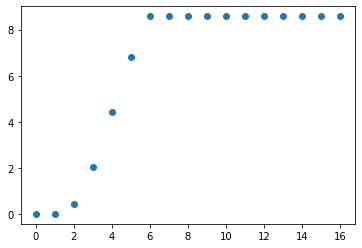

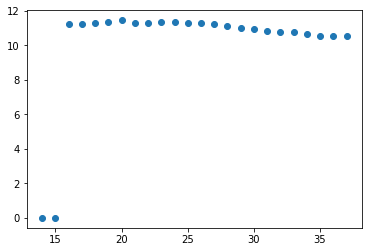

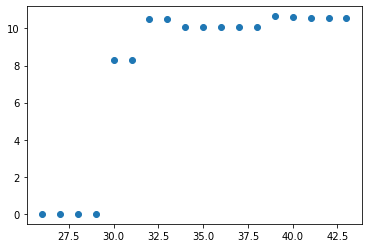

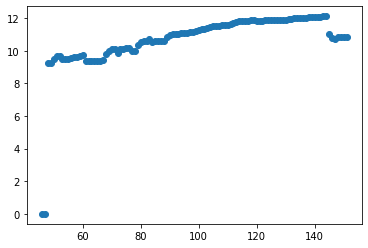

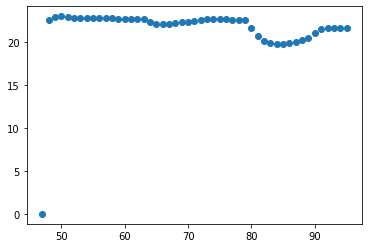

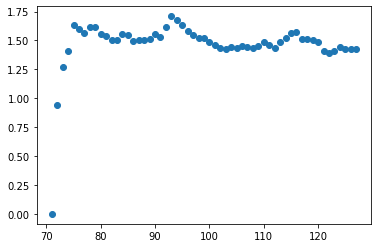

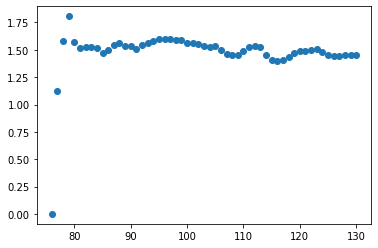

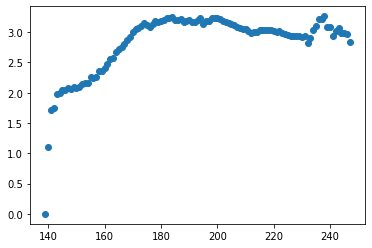

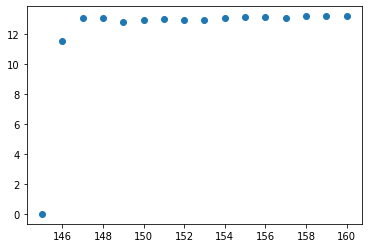

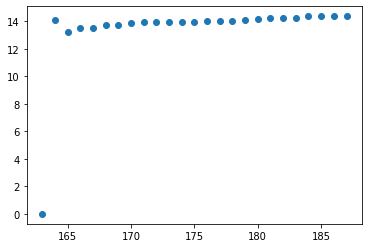

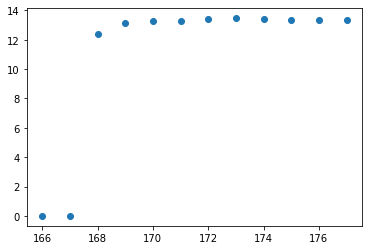

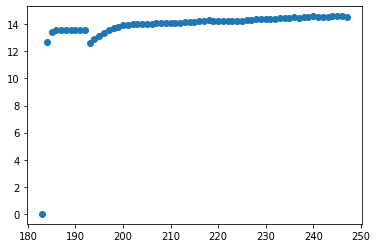

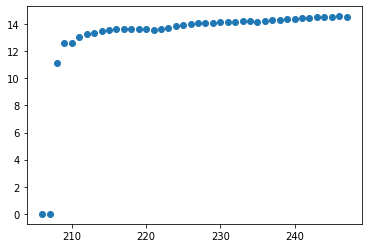

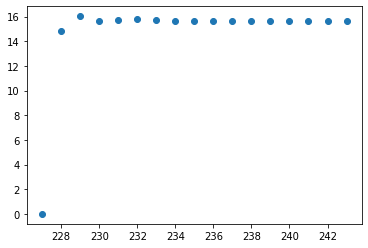

In [86]:
for agent_num in range(len(tags)):
    if len(getWithout(tags[agent_num],-1))>10 and getAverageSpeed(agent_num,vels)>1:
        plotAgentSpeed(agent_num,vels)
        print(agent_num)
        #dens = getAgentDensities(agent_num,tags,agents,frames,3,[0,0])
        #plotAgentDensity(dens)

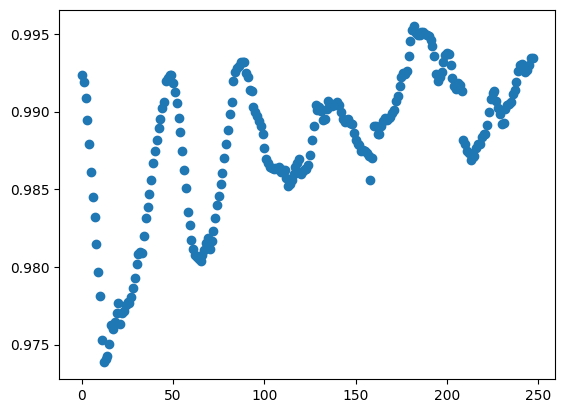

In [46]:
plotAgentYaw(0,d.dataframe['yaw'])

In [85]:
findPathMatch(coords,coords[0][150],coords[0][200])

0
1388


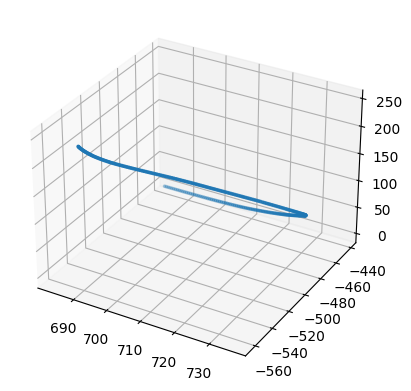

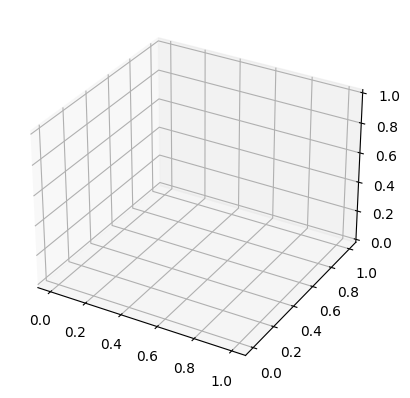

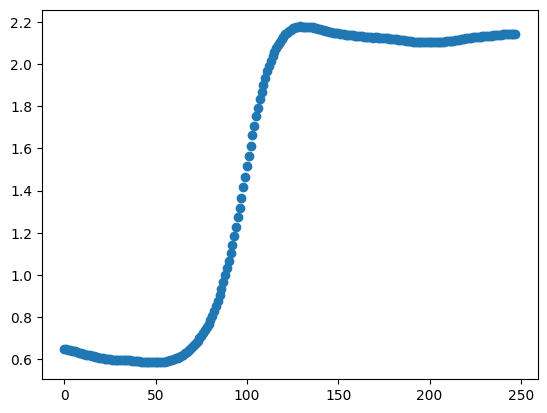

In [233]:
ret = getData(scenes[39],frames,agents)
k = 0
plotAgentPos(k,ret['coordinates'])
plotAgentVel(k,ret['velocity'])
plotAgentYaw(k,ret['yaw'])

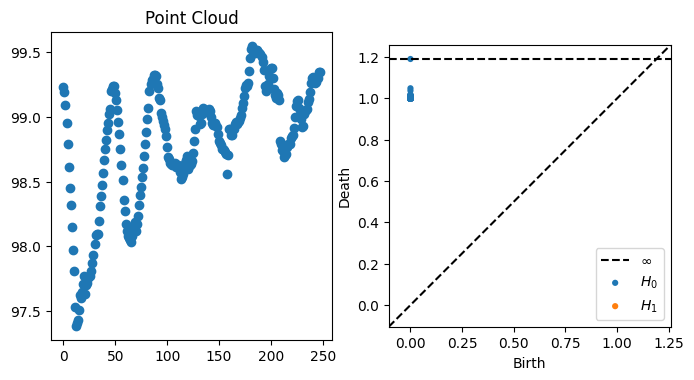

In [49]:
r = getProfileY(0,d.dataframe['yaw']*100)

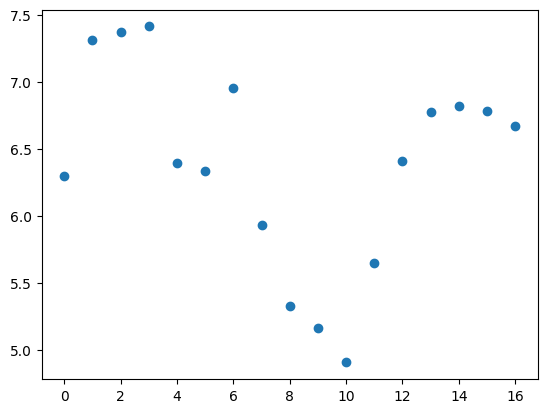

In [143]:
plotAgentDensity(dens)

In [144]:
dens

array([ 6.297826  ,  7.31426575,  7.36948213,  7.41169619,  6.39400958,
        6.33595929,  6.95334744,  5.93526378,  5.3281503 ,  5.16704652,
        4.90759468,  5.6503942 ,  6.41021862,  6.77365247,  6.81883551,
        6.7851746 ,  6.67340792, -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.        ,
       -1.        , -1.        , -1.        , -1.        , -1.  

In [140]:
dens = getAgentDensities(1,tags,agents,frames,3,[0,0])

In [52]:
vels[1]

array([[ 0.        ,  0.        ],
       [ 0.        ,  0.        ],
       [ 0.23517583,  0.37267229],
       [ 1.01263988,  1.74916482],
       [ 2.2948935 ,  3.8041594 ],
       [ 3.52881384,  5.80122185],
       [ 4.27606678,  7.43839359],
       [ 4.27609444,  7.43843794],
       [ 4.27585411,  7.43861198],
       [ 4.27602816,  7.43853426],
       [ 4.27591991,  7.4386096 ],
       [ 4.27936029,  7.43663883],
       [ 4.27839565,  7.43719864],
       [ 4.2775197 ,  7.43770552],
       [ 4.27677631,  7.43813467],
       [ 4.27679014,  7.43812799],
       [ 4.2761507 ,  7.43849611],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        , -1.        ],
       [-1.        ,

In [51]:
getAgentDensities(1,tags,agents,frames,1,[0,0])

array([3.94318379, 4.06797361, 4.03475851, 3.97023813, 3.44377984,
       2.62880611, 3.1361793 , 3.71996543, 3.49935208, 4.1999733 ,
       4.35825194, 3.93083978, 3.50336864, 3.43085643, 3.12693666,
       2.79918965, 3.88371377, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [40]:
getDensitiesMoving(1,coords,frames)

array([array([1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        ,   23.52555609,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        ]),
       array([1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        , 1000.        , 1000.        , 1000.        ,
       1000.        ,   37.61337994, 1000.        , 1000.        ,
       10

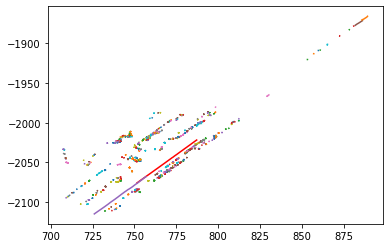

In [119]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,100:150,0], coords[0,100:150, 1],color = 'red')
for j in range(1,2000):
    #if (coords[j,:99,0]!=0).sum()>50:
    plt.plot(getWithout(coords[j,100:150,0],0),getWithout(coords[j,100:150,1],0))

plt.show()


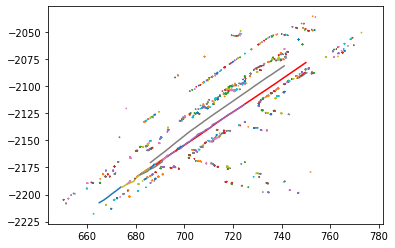

In [15]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,:99,0], coords[0,:99, 1],color = 'red')
for j in range(1,2000):
    #if (coords[j,:99,0]!=0).sum()>50:
    plt.plot(getWithout(coords[j,:99,0],0),getWithout(coords[j,:99,1],0))

plt.show()


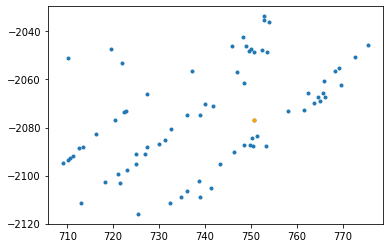

In [14]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,99,0], coords[0,99, 1],color = 'orange',marker = '.')

ax.scatter(getWithout(coords[:,99,0],0),getWithout(coords[:,99,1],0),marker = '.')

plt.show()


In [251]:
for agent in agents[1000:10000]:
    print(agent['label_probabilities'].nonzero()[0][0]!=1 and agent['label_probabilities'].nonzero()[0][0]!=3)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

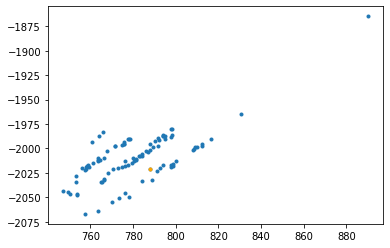

In [17]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,150,0], coords[0,150, 1],color = 'orange',marker = '.')

ax.scatter(getWithout(coords[:,150,0],0),getWithout(coords[:,150,1],0),marker = '.')

plt.show()

In [7]:
def getVelocity(scene,frames):
    coords = -1 * np.ones((2000,scene[0][1]-scene[0][0],2))
    for i in tqdm(range(scene[0][0],scene[0][1])):
        frame = frames[i]
        for j in range(frame[1][0],frame[1][1]):
            agent = agents[j]
            coords[agent[-2]][i-scene[0][0]] = agent[3]
    return coords

100%|████████████████████████████████████████| 249/249 [02:08<00:00,  1.93it/s]


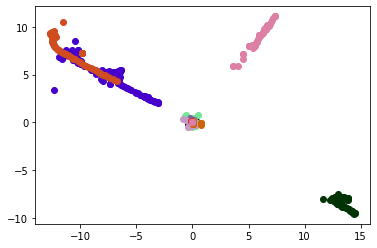

In [10]:
vels = getVelocity(scenes[1],frames)
graphVelocity(vels)

In [12]:
agents[0]

([  665.03424072, -2207.51220703], [4.3913283, 1.8138304, 1.5909758], 1.0166751, [0., 0.], 1, [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
def getProfileY(agent_num,vels):
    vel = vels[agent_num]
    
    X = np.zeros((len(getWithout(vel[:,0],2)),2))
    X[:,0] = (np.arange(len(vel[:,0]))[vel[:,0]!=2])
    X[:,1] = (getWithout(vel[:,0],2))
    
    dgms = ripser(X)['dgms']

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter((np.arange(len(vel[:,0]))[vel[:,0]!=2]),(getWithout(vel[:,0],2)))

    plt.title("Point Cloud")
    plt.subplot(122)
    plot_diagrams(dgms)
    plt.show()
    return X

In [20]:
def getProfile(agent_num,vels):
    vel = vels[agent_num]
    
    X = np.zeros((len(getWithout(vel[:,0],-1)),2))
    X[:,0] = (np.arange(len(vel[:,0]))[vel[:,0]!=-1])
    X[:,1] = (getWithout(vel[:,0],-1)**2 + getWithout(vel[:,1],-1)**2)**0.5
    
    dgms = ripser(X)['dgms']

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter((np.arange(len(vel[:,0]))[vel[:,0]!=-1])[1:],(getWithout(vel[:,0],-1)**2 + getWithout(vel[:,1],-1)**2)[1:]**0.5)

    plt.title("Point Cloud")
    plt.subplot(122)
    plot_diagrams(dgms)
    plt.show()
    return X

In [9]:
def graphVelocity(coords):
    fig,ax = plt.subplots()
    for j in range(1,2000):
        if (coords[j,:,0]!=-1).sum() > 50:
            ax.scatter(coords[j,:,0][coords[j,:,0]!=-1],coords[j,:,1][coords[j,:,1]!=-1],color = ((j%1000)/1000.0,(j%10)/10.0,(j%100)/100.0),label = j)

    #ax.legend()
    plt.show()

In [38]:
def distance_from_center(agent1, agent2):
    '''
    Calculates the distance between the centroids of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distk ance between the two agents' centroids
    '''
    return np.linalg.norm(agent1['centroid'] - agent2['centroid'])

def distance_from_edge(agent1, agent2):
    '''
    Calculates the distance between the closest edges of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distance between two agents' closest edges
    '''
        
    # generate orthogonal axes for each agent
    a1_length_axis = agent1['extent'][1] / 2 * np.array([np.cos(agent1['yaw']), np.sin(agent1['yaw'])])
    a1_width_axis  = agent1['extent'][0] / 2 * np.array([np.sin(agent1['yaw']), np.cos(agent1['yaw'])])
    a2_length_axis = agent2['extent'][1] / 2 * np.array([np.cos(agent2['yaw']), np.sin(agent2['yaw'])])
    a2_width_axis  = agent2['extent'][0] / 2 * np.array([np.sin(agent2['yaw']), np.cos(agent2['yaw'])])
        
    # find all of the corners
    a1_corners = np.asarray([agent1['centroid'] + a1_length_axis * a + a1_width_axis * a for a in [-1, 1]])
    a2_corners = np.asarray([agent2['centroid'] + a2_length_axis * a + a2_width_axis * a for a in [-1, 1]])
    
    # convert corners into cartesian intervals
    a1_max = np.maximum(*a1_corners)
    a1_min = np.minimum(*a1_corners)
    a2_max = np.maximum(*a2_corners)
    a2_min = np.minimum(*a2_corners)
    
    # compute minkowski distance for rectangles
    y = np.maximum(0, np.maximum(a1_min - a2_max, a2_min - a1_max))
    
    return np.sum(np.abs(y) ** 2, axis=-1) ** (1/2)

In [8]:
distance_from_center(dataset[1], dataset[5])

88.71618250270556

In [9]:
distance_from_edge(dataset[1], dataset[5])

85.06367486122527

In [118]:
def getAgentData(scene,frames):
    coords = np.zeros((2000,scene[0][1]-scene[0][0],2)) #2000 is arbitrary number
    vels = -1 * np.ones((2000,scene[0][1]-scene[0][0],2)) #2000 is arbitrary number
    tags = -1 * np.ones((2000,scene[0][1]-scene[0][0])) #2000 is arbitrary number
    yaws = 2 * np.ones((2000,scene[0][1]-scene[0][0])) #2000 is arbitrary number
    for frame_counter,frame_num in enumerate(tqdm(range(scene[0][0],scene[0][1]))):
        frame = frames[frame_num]
        coords[0][frame_counter] = frame[3][:2]
        yaws[0][frame_counter] = math.acos(frame[4][0][0])
        for j in range(frame[1][0],frame[1][1]):
            agent = agents[j]
            coords[agent[4]][frame_counter] = agent[0]
            vels[agent[4]][frame_counter] = agent[3]
            tags[agent[4]][frame_counter] = j
            yaws[agent[4]][frame_counter] = agent[2]
    return coords,vels,tags.astype(int),yaws

def getWithout(arr,n):
    return arr[arr!=n]

def getAverageSpeed(agent_num,vels):
    return np.mean(getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

def getDensitiesAll(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num][1][1]-frames[frame_num][1][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num][1][0],frames[frame_num][1][1])):
            #print(distance_from_edge(agents[agent_index],agents[pos[frame_num]]))
            #print(distance_from_center(agents[agent_index],agents[pos[frame_num]]))
            temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
        densities.append(temp)
    return np.array(densities,dtype = object)

def getDensitiesMoving(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num][1][1]-frames[frame_num][1][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num][1][0],frames[frame_num]['agent_index_interval'][1])):
            if math.hypot(agents[agent_index][3][0],agents[agent_index][3][1]) > 1:
                temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
            else:
                temp[agent_count] = 1000
        densities.append(temp)
    return np.array(densities,dtype = object)

def returnDensitiesDistances(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = np.sort(densities[frame_num])[k+1]
    return dist_densities

def returnDensitiesRadius(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = (densities[frame_num]<k).sum()
    return dist_densities

def getAgentDensities(agent_num,tags,agents,frames,k,t):
    if t[0] == 0:
        densities = getDensitiesAll(agent_num,tags,agents,frames)
    else:
        densities = getDensitiesMoving(agent_num,tags,agents,frames)
    if t[1] == 0:
        ret = returnDensitiesDistances(densities,k)
    else:
        ret = returnDensitiesRadius(densities,k)
    return ret

def plotAgentPos(agent_num,coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(coords[agent_num][:,0],0),getWithout(coords[agent_num][:,1],0),zs = np.arange(len(coords[agent_num]))[coords[agent_num][:,0]!=0],s=3)
    plt.show()
    
def plotAgentVel(agent_num,vels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(vels[agent_num][:,0],-1),getWithout(vels[agent_num][:,1],-1),zs = np.arange(len(vels[agent_num]))[vels[agent_num][:,0]!=-1],s=3)
    plt.show()
    
def plotAgentYaw(agent_num,yaws):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(yaws[agent_num]))[yaws[agent_num]!=2],getWithout(yaws[agent_num],2))
    plt.show()
    
def plotAgentSpeed(agent_num,vels):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(vels[agent_num]))[vels[agent_num][:,0]!=-1],getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

def plotAgentDensity(agent_density):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(agent_density))[agent_density!=-1],getWithout(agent_density,-1))